# **Delivery Time Estimation**

#### **Problem**

The business wants to evaluate the Estimated Delivery Time on the basis of
- What they are ordering?
- From Where they are ordering
- The availibilty of Delivery Partners
- etc

I'll explore the data to find hidden stories and since this is a Regression task, I'll use Neural Networks to estimate the same.

# Data Initialization

In [1]:
# Importing required libraries
from pyspark.sql import SparkSession
from numba import jit

In [2]:
# Pyspark Java Setup

import os

# Set the JAVA_HOME environment variable
os.environ['JAVA_HOME'] = '/home/studio-lab-user/.conda/envs/delivery_time_torch'
os.environ['PATH'] = os.environ['JAVA_HOME'] + '/bin:' + os.environ['PATH']

In [3]:
# Initiallizing Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/30 03:40:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Adjust Spark session settings to improve display
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 50)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 100)
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
# Investigating Dataset
df = spark.read.csv('../data/raw/data.csv', header=True, inferSchema=True)
df.limit(5)

24/05/30 03:40:53 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NULL,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NULL,1.0,6,6900,5,600,1800,1.0,1.0,2.0
3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NULL,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


In [6]:
# Shape of the dataset

print(f"Shape of DataFrame: (rows: {df.count()}, columns: {len(df.columns)})")

Shape of DataFrame: (rows: 197428, columns: 14)


**Observe**
- We have 14 features and almost 200K datapoints
- Data seems to be small

In [7]:
# Datatypes Info
df.printSchema()

root
 |-- market_id: double (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- actual_delivery_time: timestamp (nullable = true)
 |-- store_id: string (nullable = true)
 |-- store_primary_category: string (nullable = true)
 |-- order_protocol: double (nullable = true)
 |-- total_items: integer (nullable = true)
 |-- subtotal: integer (nullable = true)
 |-- num_distinct_items: integer (nullable = true)
 |-- min_item_price: integer (nullable = true)
 |-- max_item_price: integer (nullable = true)
 |-- total_onshift_partners: double (nullable = true)
 |-- total_busy_partners: double (nullable = true)
 |-- total_outstanding_orders: double (nullable = true)



In [8]:
# Filtering columns on the basis of Data Types

from pyspark.sql.types import IntegerType, StringType, NumericType, TimestampType

continuous_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]
categorical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
temporal_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, TimestampType)]

In [9]:
# Null Values

from pyspark.sql.functions import col, count, when

df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).toPandas().transpose()/df.count() * 100

,0
market_id,0.499929
created_at,0.000000
actual_delivery_time,0.003546
store_id,0.000000
store_primary_category,2.411006
order_protocol,0.503981
total_items,0.000000
subtotal,0.000000
num_distinct_items,0.000000
min_item_price,0.000000


**Observe**
- Need to treat many Null Values, Cannot drop

In [10]:
# Statistics Summary
df.select(*continuous_cols).summary().toPandas().transpose()

24/05/30 03:41:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
market_id,196441,2.978706074597462,1.5248667244506284,1.0,2.0,3.0,4.0,6.0
order_protocol,196433,2.8823517433425137,1.5037712034995787,1.0,1.0,3.0,4.0,7.0
total_items,197428,3.196390582896043,2.6665460635998874,1,2,3,4,411
subtotal,197428,2682.331401827502,1823.0936878547845,0,1400,2200,3395,27100
num_distinct_items,197428,2.6707913771096297,1.630255241338155,1,1,2,3,20
min_item_price,197428,686.2184695180015,522.0386476914737,-86,299,595,949,14700
max_item_price,197428,1159.5886297789573,558.4113766592675,0,800,1095,1395,14700
total_onshift_partners,181166,44.808093130057514,34.526783476213446,-4.0,17.0,37.0,65.0,171.0
total_busy_partners,181166,41.739746972389966,32.145732718031816,-5.0,15.0,34.0,62.0,154.0


**Observe**
- Higher Outliers observed in Subtotals, indicating the field is affected by extremes
- Also thorough investigation is required for the Negative values observed in the Item price, orders and partners

In [11]:
# Uniuqe Values Observed

from pyspark.sql.functions import countDistinct

df.agg(*(countDistinct(c).alias(c) for c in df.columns)).toPandas().transpose()

,0
market_id,6
created_at,180985
actual_delivery_time,178110
store_id,6743
store_primary_category,74
order_protocol,7
total_items,57
subtotal,8368
num_distinct_items,20
min_item_price,2312


In [12]:
# Analysze Value counts for Low Cardinal features

from pyspark.sql.functions import lit,col,round

low_cardinal = ["market_id", "order_protocol"]
for c in low_cardinal:
    display(df.groupby(c).count().withColumn( "normalized_count", round(col("count")/lit(df.count()) * 100,2) ))

market_id,count,normalized_count
NULL,987,0.5
1.0,38037,19.27
4.0,47599,24.11
3.0,23297,11.8
2.0,55058,27.89
6.0,14450,7.32
5.0,18000,9.12


order_protocol,count,normalized_count
7.0,19,0.01
NULL,995,0.5
1.0,54725,27.72
4.0,19354,9.8
3.0,53199,26.95
2.0,24052,12.18
6.0,794,0.4
5.0,44290,22.43


**Observe**
- marked_id of 2 dominates the market
- order_protocol 1 & 3 are most common protocols used to plkace order

In [13]:
# Duplicate Records
df.exceptAll(df.dropDuplicates()).count()

0

# Exploratory Data Analysis

In [14]:
# Assigning Discrete Numerical Cols to Categorical cols
discrete_cols = [ "market_id","order_protocol","num_distinct_items"]

for c in discrete_cols:
    continuous_cols.remove(c)
    categorical_cols.append(c)

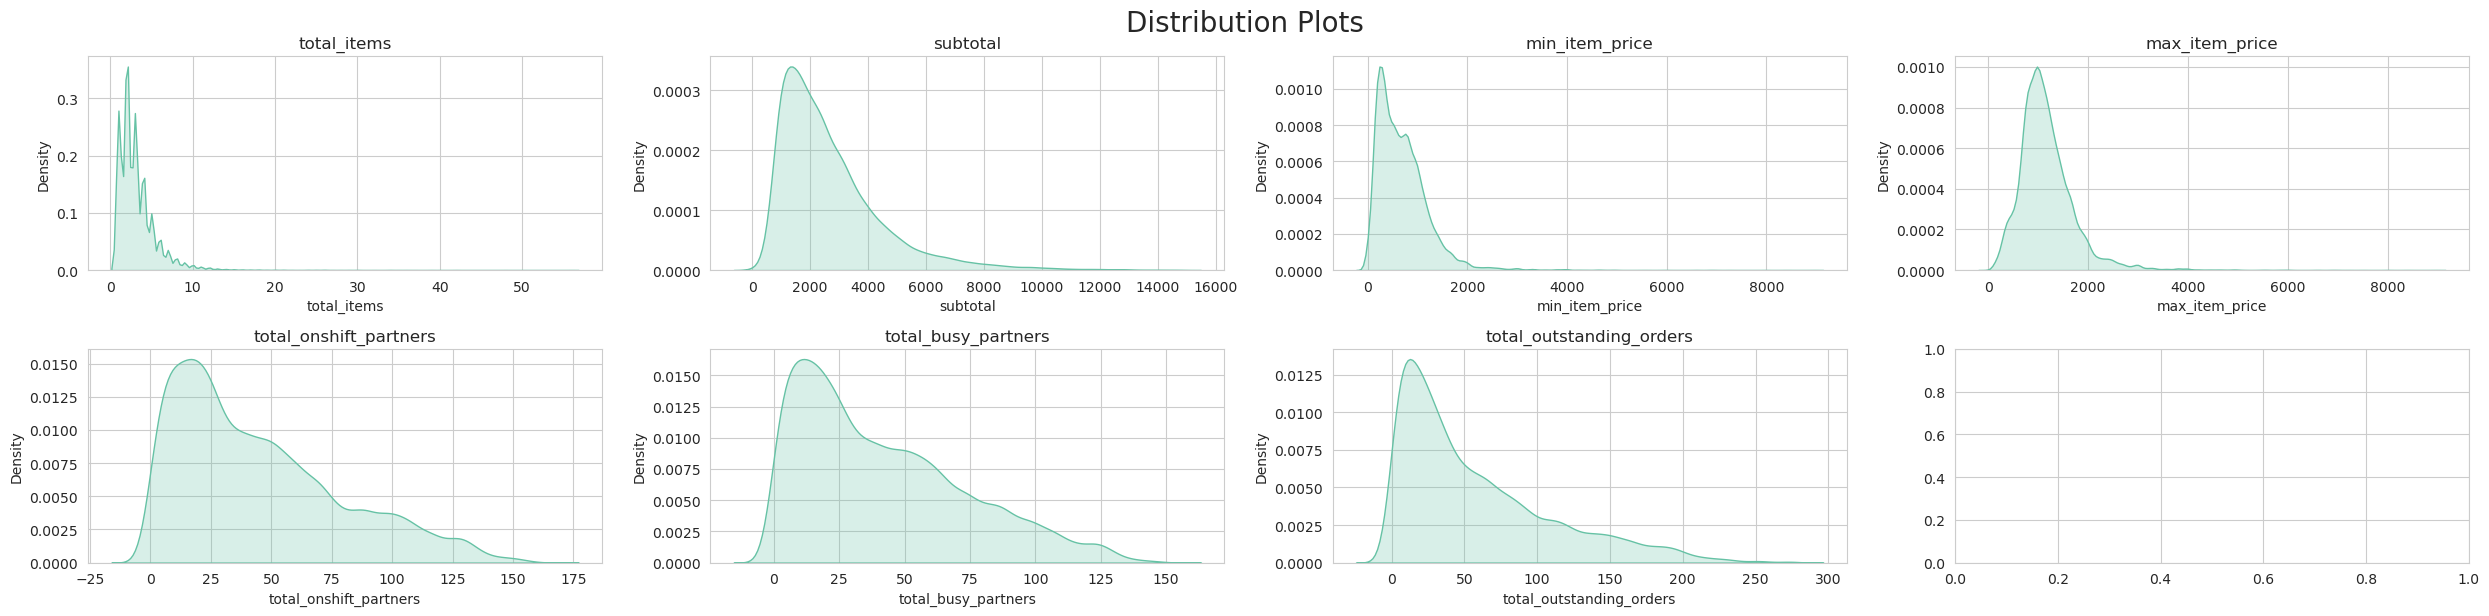

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_palette("Set2")
sns.set_style("whitegrid")

pandas_df = df.dropna().sample(False,fraction = 0.25,seed=42).toPandas()

nrows = (len(continuous_cols) // 4) + (len(continuous_cols) % 2)

fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(25, 3 * nrows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each continuous column to create distribution plots
for i, feature in enumerate(continuous_cols):
    sns.kdeplot(data=pandas_df, x=feature, fill=True, ax=axes[i] )
    axes[i].set_title(feature)

# Adjust layout
plt.tight_layout()
plt.suptitle("Distribution Plots", y=1.02, fontsize=20)
plt.show()

**Observe**
- All the distribution seems to be a part od **Log Normal** Distribution
- total_items is highly skewed indicating large presence of outliers

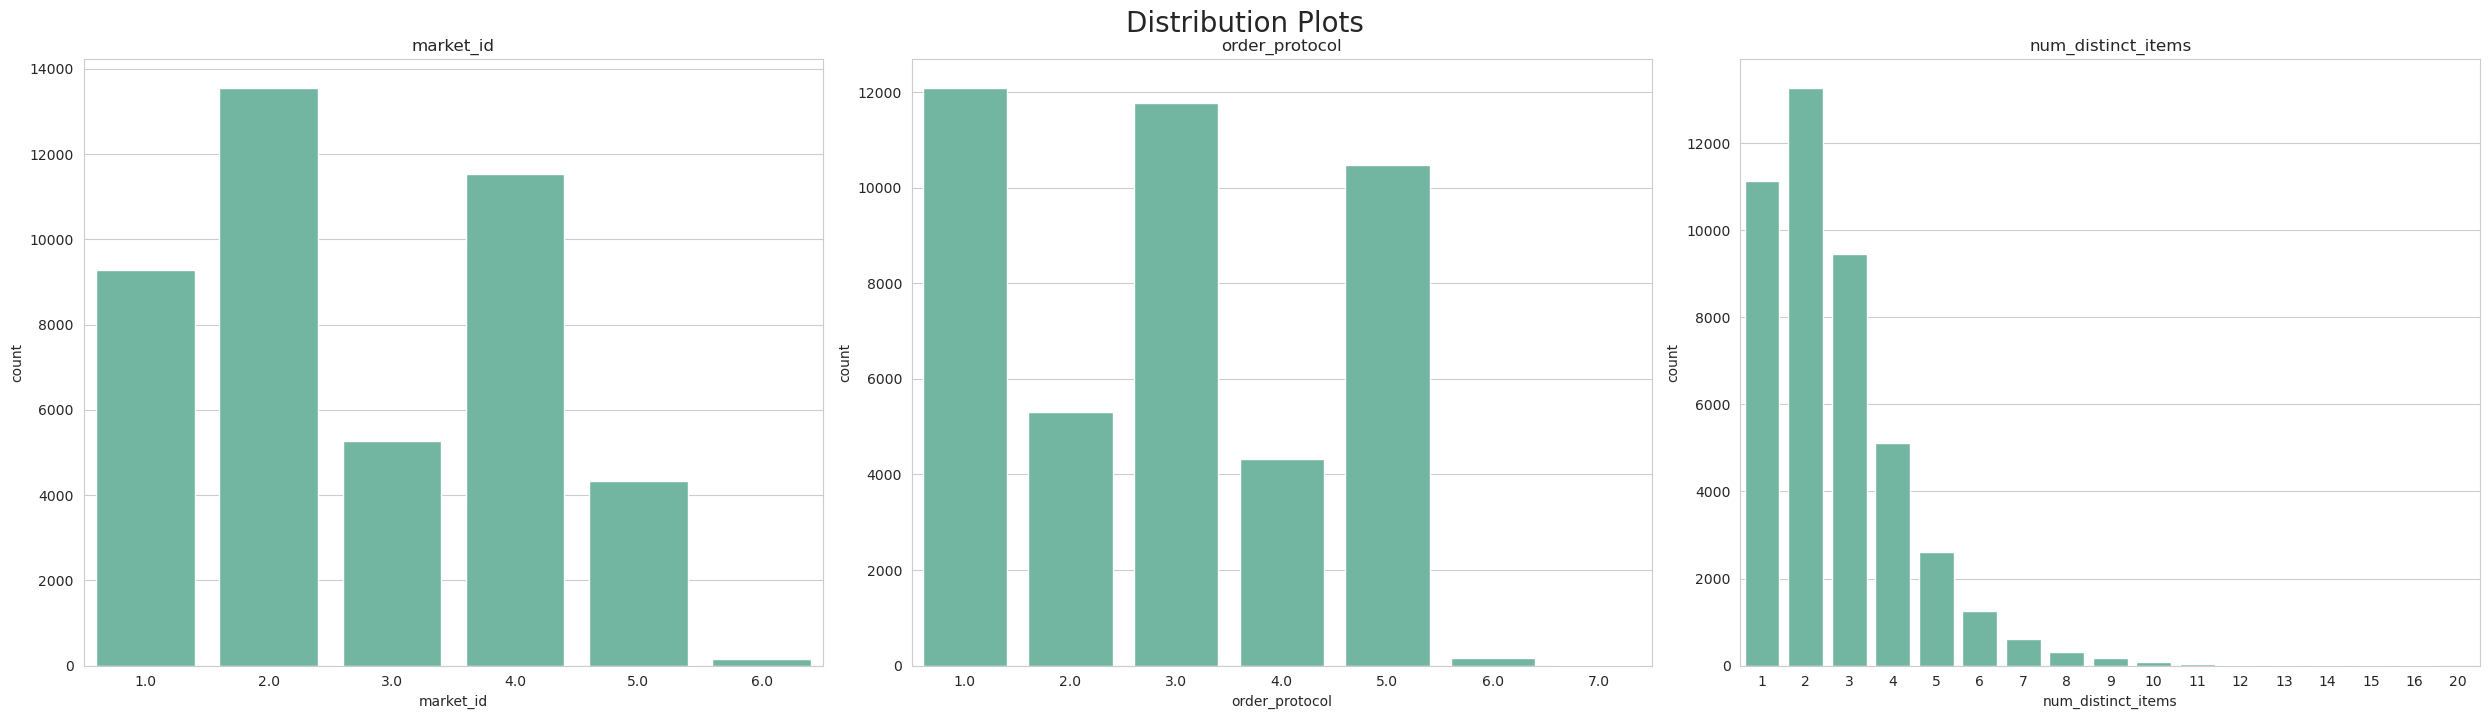

In [16]:
# Analyzing Categoriacal Columns

nrows = 1

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(25, 5 * nrows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Counter for axes fixing
counter = 0

# Loop through each continuous column to create distribution plots
for i, feature in enumerate(categorical_cols):
    if feature == 'store_id' or feature == 'store_primary_category': 
        counter += 1
        continue
    sns.countplot(data=pandas_df, x=feature, ax=axes[i-counter] )
    axes[i-counter].set_title(feature)

# Adjust layout
plt.tight_layout()

plt.suptitle("Distribution Plots", y=1.02, fontsize=20)
plt.show()

**Observe**
- 1, 3 & 5 common 

In [17]:
# Creating target variable for further analysis

from pyspark.sql.functions import col,round

df = df.withColumn("eta", round((col("actual_delivery_time").cast("long") - col("created_at").cast("long"))/60))
df.limit(3)

market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,eta
1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,63.0
2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.0
3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NULL,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,30.0


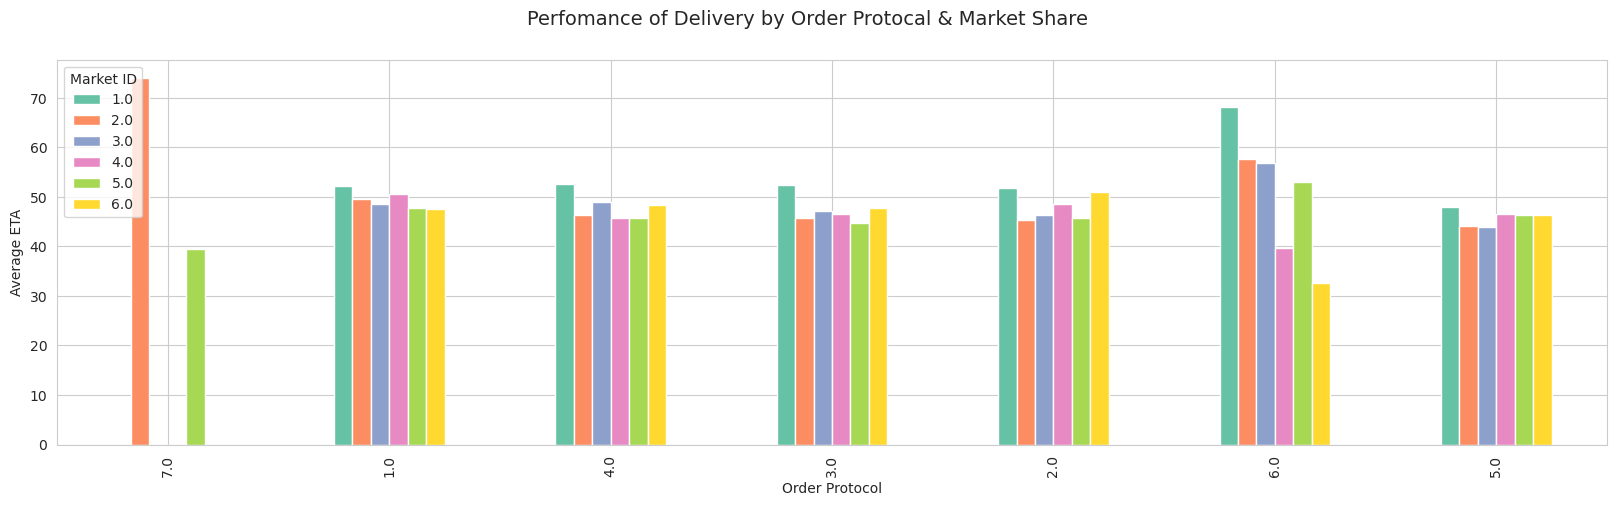

In [18]:
# ----Does the perfomance of delivery depends on order_protocol and market_id?----
from pyspark.sql.functions import avg

pandas_df = df.dropna()

grouped_df = pandas_df.groupby("order_protocol", "market_id").agg(avg("eta").alias("avg_eta"))
pivot_df = grouped_df.groupby("order_protocol").pivot("market_id").avg("avg_eta").fillna(0).toPandas().set_index("order_protocol")

pivot_df.plot(kind = "bar", stacked=False, figsize = (20,5))
plt.suptitle("Perfomance of Delivery by Order Protocal & Market Share", fontsize=14)
plt.xlabel('Order Protocol')
plt.ylabel('Average ETA')
plt.legend(title='Market ID')
plt.show()

**Obseerve**
- In Order Protocol 7, Not all market_id participates and order from market_id 2 takes most time to deliver.
- Order Protocol 6 is delivered fastest from market_id 6 and slowest from market_id 1

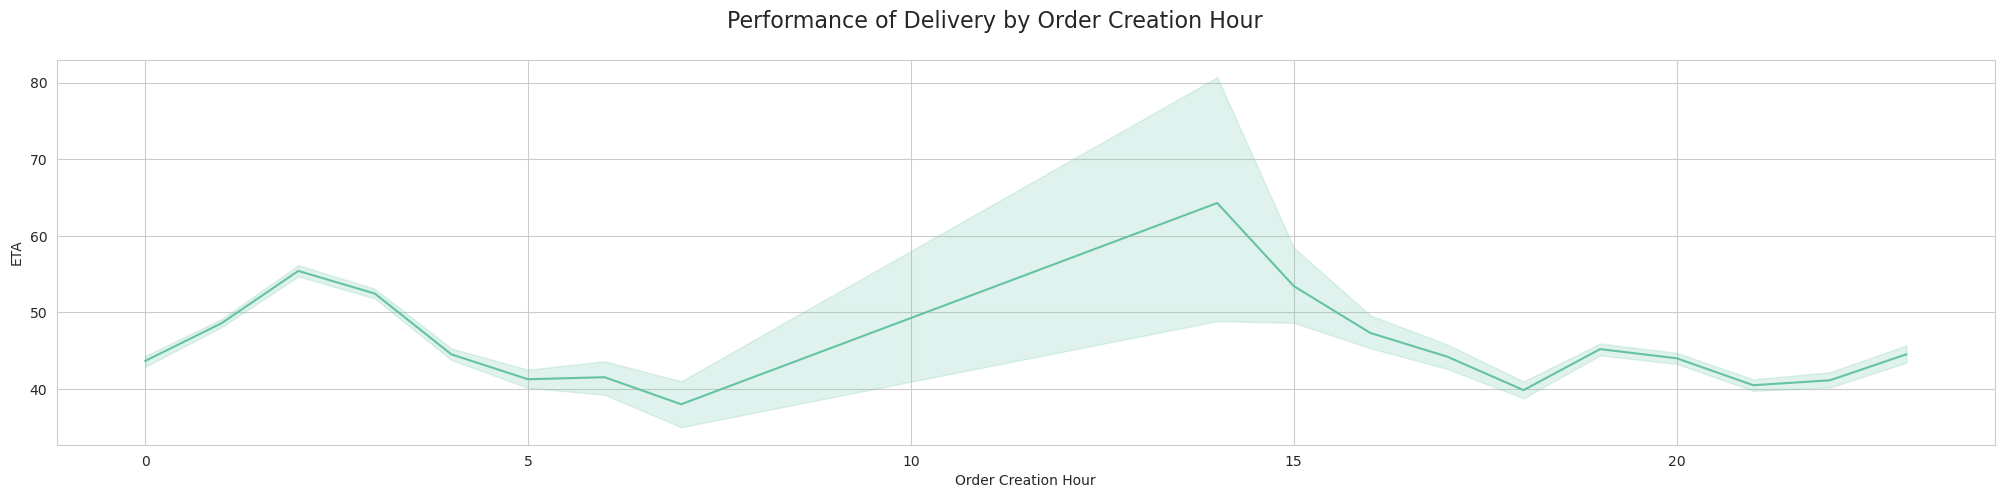

In [19]:
#----Effect of hour on ETA----

from pyspark.sql.functions import hour,col

# Extract hour column from created at
df = df.withColumn("hour", hour(col('created_at')))

pandas_df = df.dropna().sample(False,0.15,seed=42).toPandas()

plt.figure(figsize=(25,5))
sns.lineplot(x=pandas_df["hour"],y=pandas_df["eta"])
plt.suptitle("Performance of Delivery by Order Creation Hour", fontsize=16)
plt.xlabel('Order Creation Hour')
plt.ylabel('ETA')
plt.show()   

**Observe**
- Order takes more eta to deliver when it is placed during afternoon.

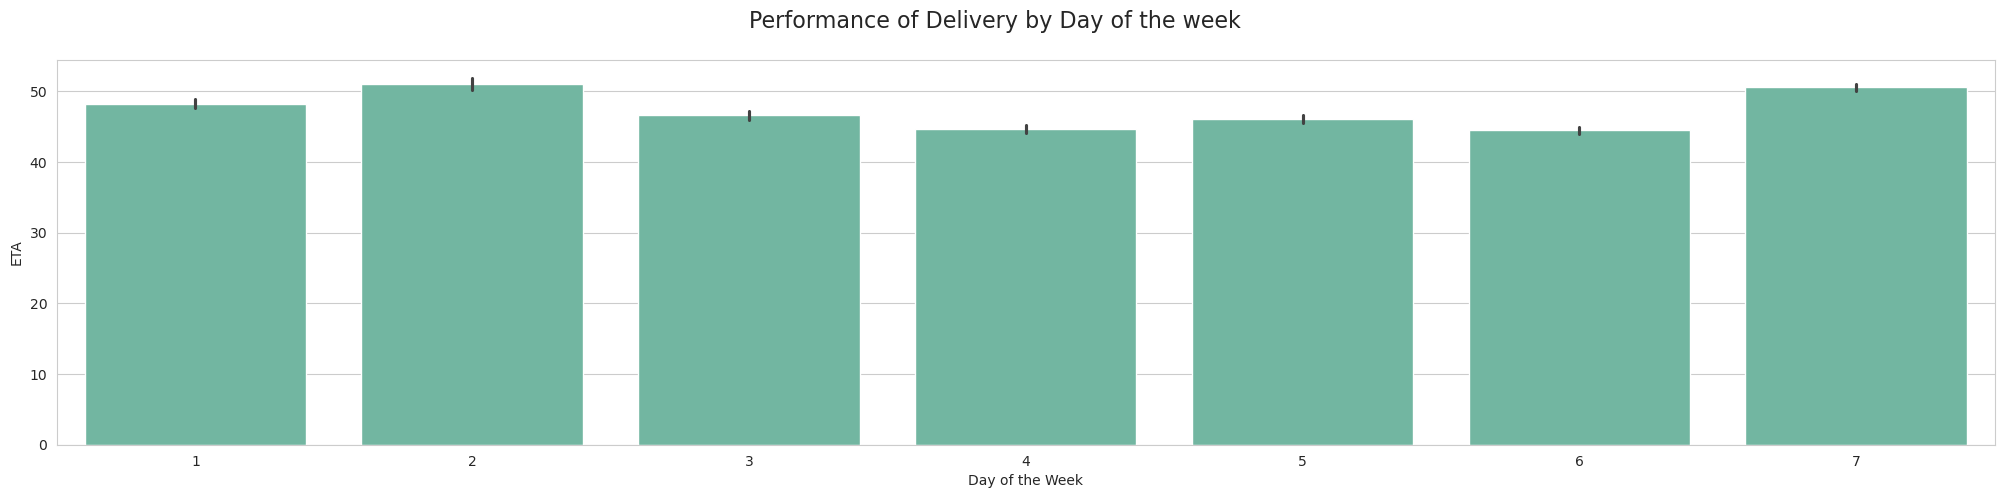

In [57]:
#----Effect of weekday on ETA----

from pyspark.sql.functions import dayofweek

# Extract hour column from created at
df = df.withColumn("day_of_week", dayofweek(col('created_at')))

pandas_df = df.dropna().sample(False,0.15,seed=42).toPandas()

plt.figure(figsize=(25,5))
sns.barplot(x=pandas_df["day_of_week"],y=pandas_df["eta"])
plt.suptitle("Performance of Delivery by Day of the week", fontsize=16)
plt.xlabel('Day of the Week')
plt.ylabel('ETA')
plt.show()   


In [58]:
# Appending New Feature to respective columns
categorical_cols.append('day_of_week')
categorical_cols.append('hour')
targer_var = 'eta'

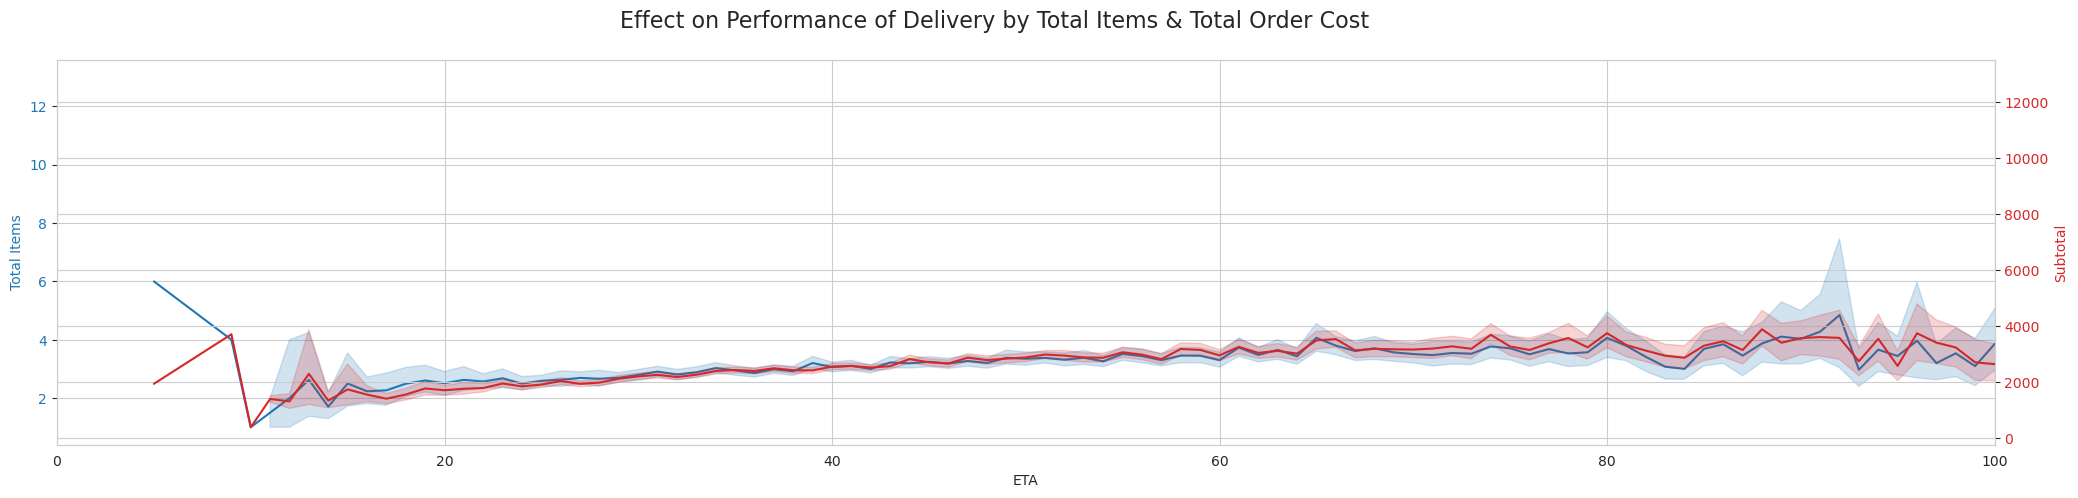

In [20]:
###----Effect on Perfomance of Delivery by Total Items & Total Order Cost---

fig, ax1 = plt.subplots(figsize=(25, 5))

# Plot total_items on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('ETA')
ax1.set_ylabel('Total Items', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["total_items"], ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Subtotal', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["subtotal"], ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and show the plot
plt.suptitle("Effect on Performance of Delivery by Total Items & Total Order Cost", fontsize=16)
plt.xlim(0,100)
plt.show()

**Observe**
- No concrete visual pattern observed between Items Order COst and eta

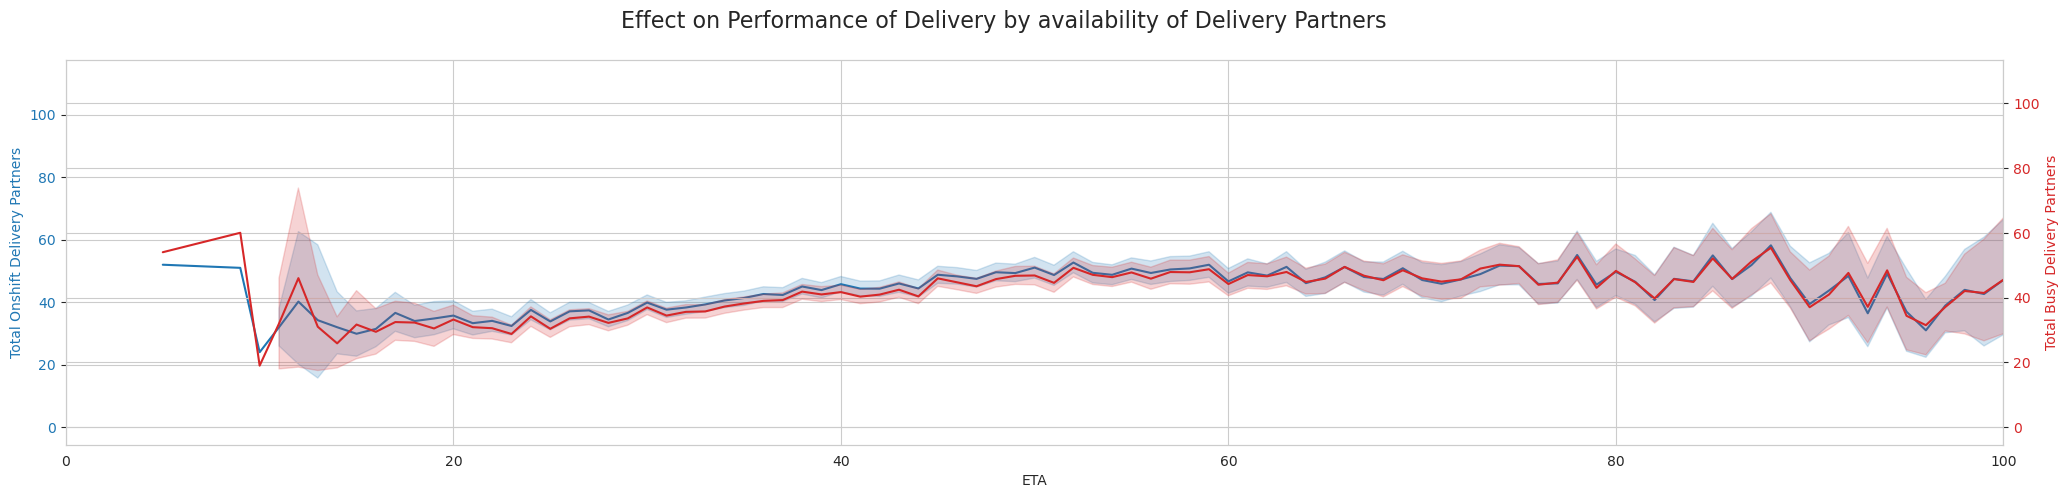

In [21]:
###----Anlayze connection between total_onshift_partners 7 total_busy_partners w.r.t to eta---

###----Effect on Perfomance of Delivery by Total Items & Total Order Cost---

fig, ax1 = plt.subplots(figsize=(25, 5))

# Plot total_items on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('ETA')
ax1.set_ylabel('Total Onshift Delivery Partners', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["total_onshift_partners"], ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Busy Delivery Partners', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["total_busy_partners"], ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and show the plot
plt.suptitle("Effect on Performance of Delivery by availability of Delivery Partners", fontsize=16)
plt.xlim(0,100)
plt.show()

**Observe**
- No concrete information could be gathered from the visuals

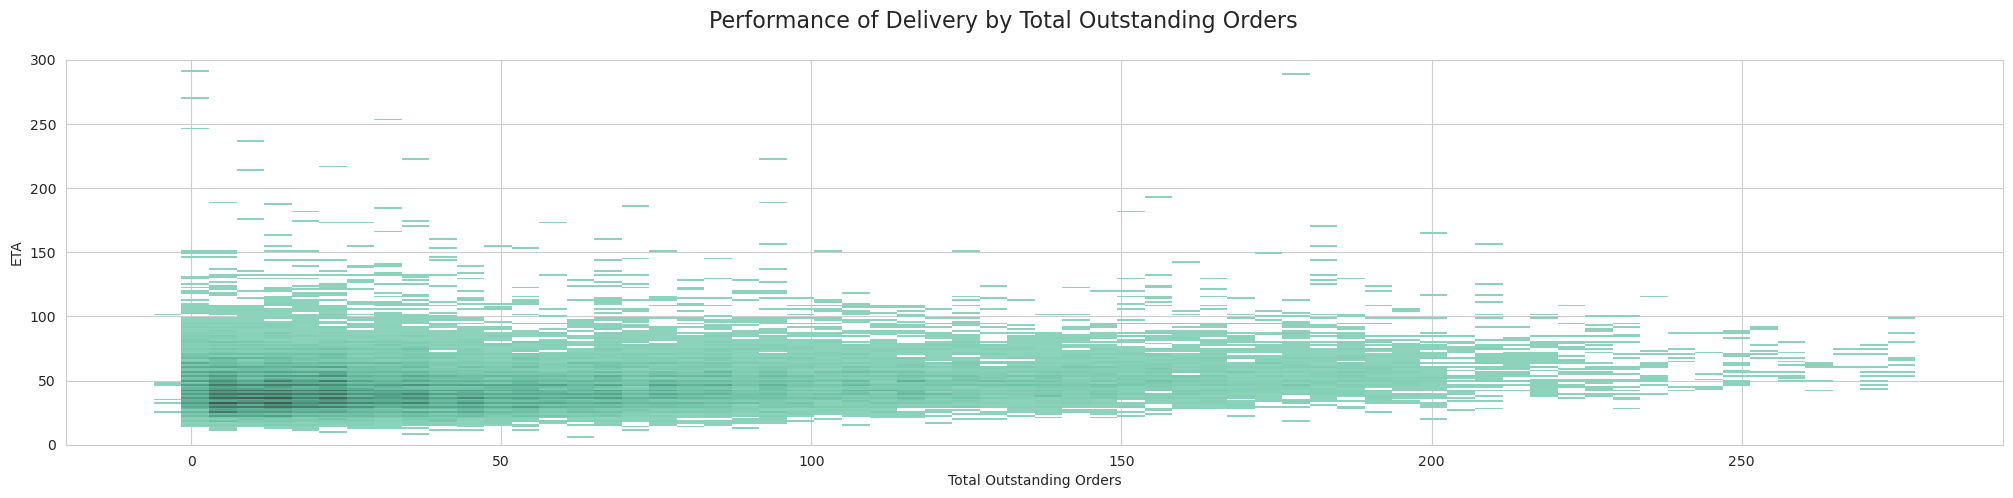

In [22]:
#---Total Outstaning Orders and Eta---
plt.figure(figsize=(25,5))
sns.histplot(data=pandas_df, x='total_outstanding_orders', y = 'eta')
plt.ylim(0,300)
plt.suptitle("Performance of Delivery by Total Outstanding Orders", fontsize=16)
plt.xlabel('Total Outstanding Orders')
plt.ylabel('ETA')
plt.show()  

**Observe**
- No significant effect was found

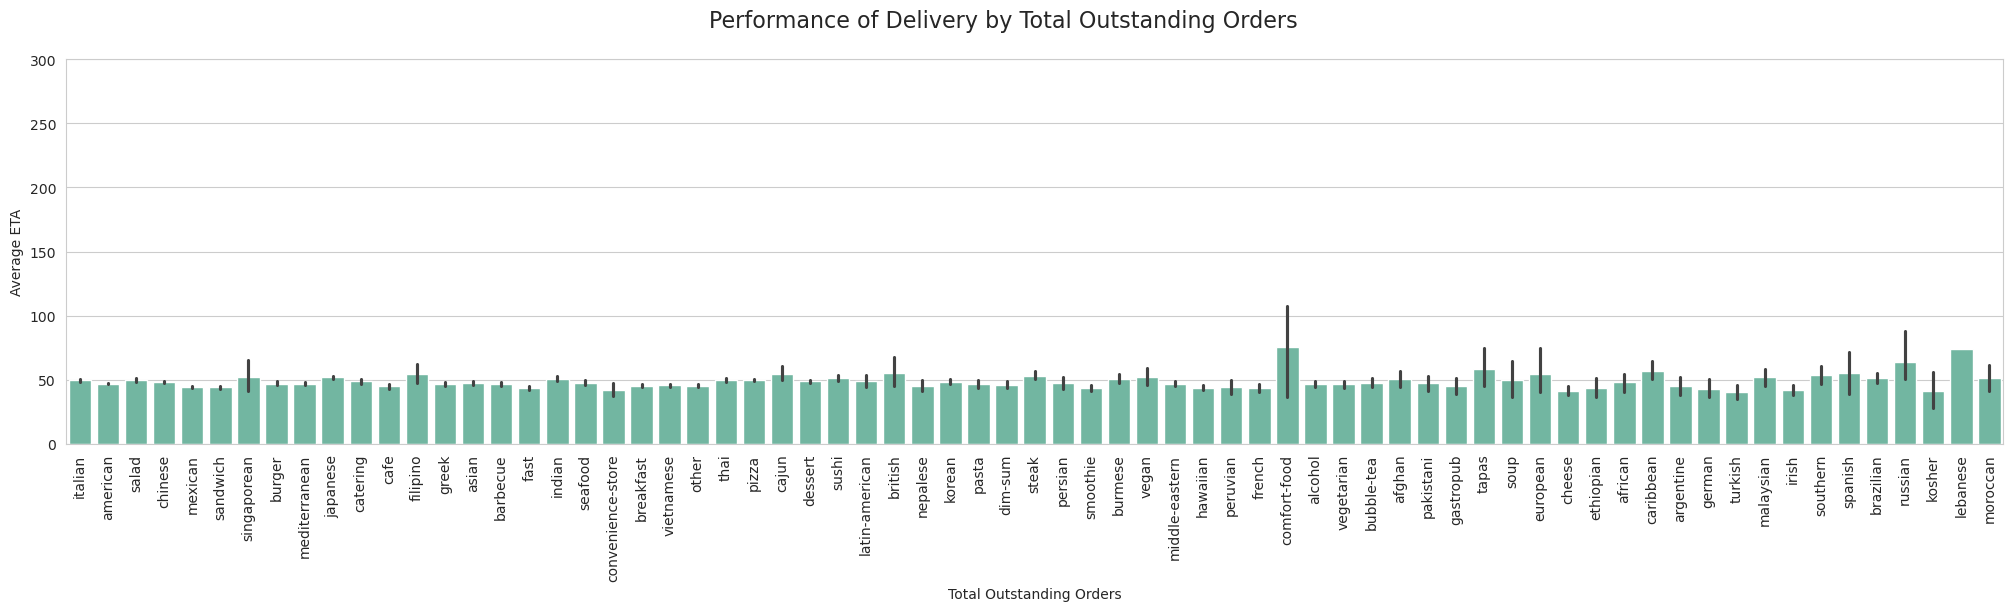

In [23]:
#---Analysis between ETA and Store Primary Category---
plt.figure(figsize=(25,5))
sns.barplot(data=pandas_df, x='store_primary_category', y = 'eta')
plt.ylim(0,300)
plt.suptitle("Performance of Delivery by Total Outstanding Orders", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('Total Outstanding Orders')
plt.ylabel('Average ETA')
plt.show()  

**Observe**
- Comfort Food generally takes more time to deliver.

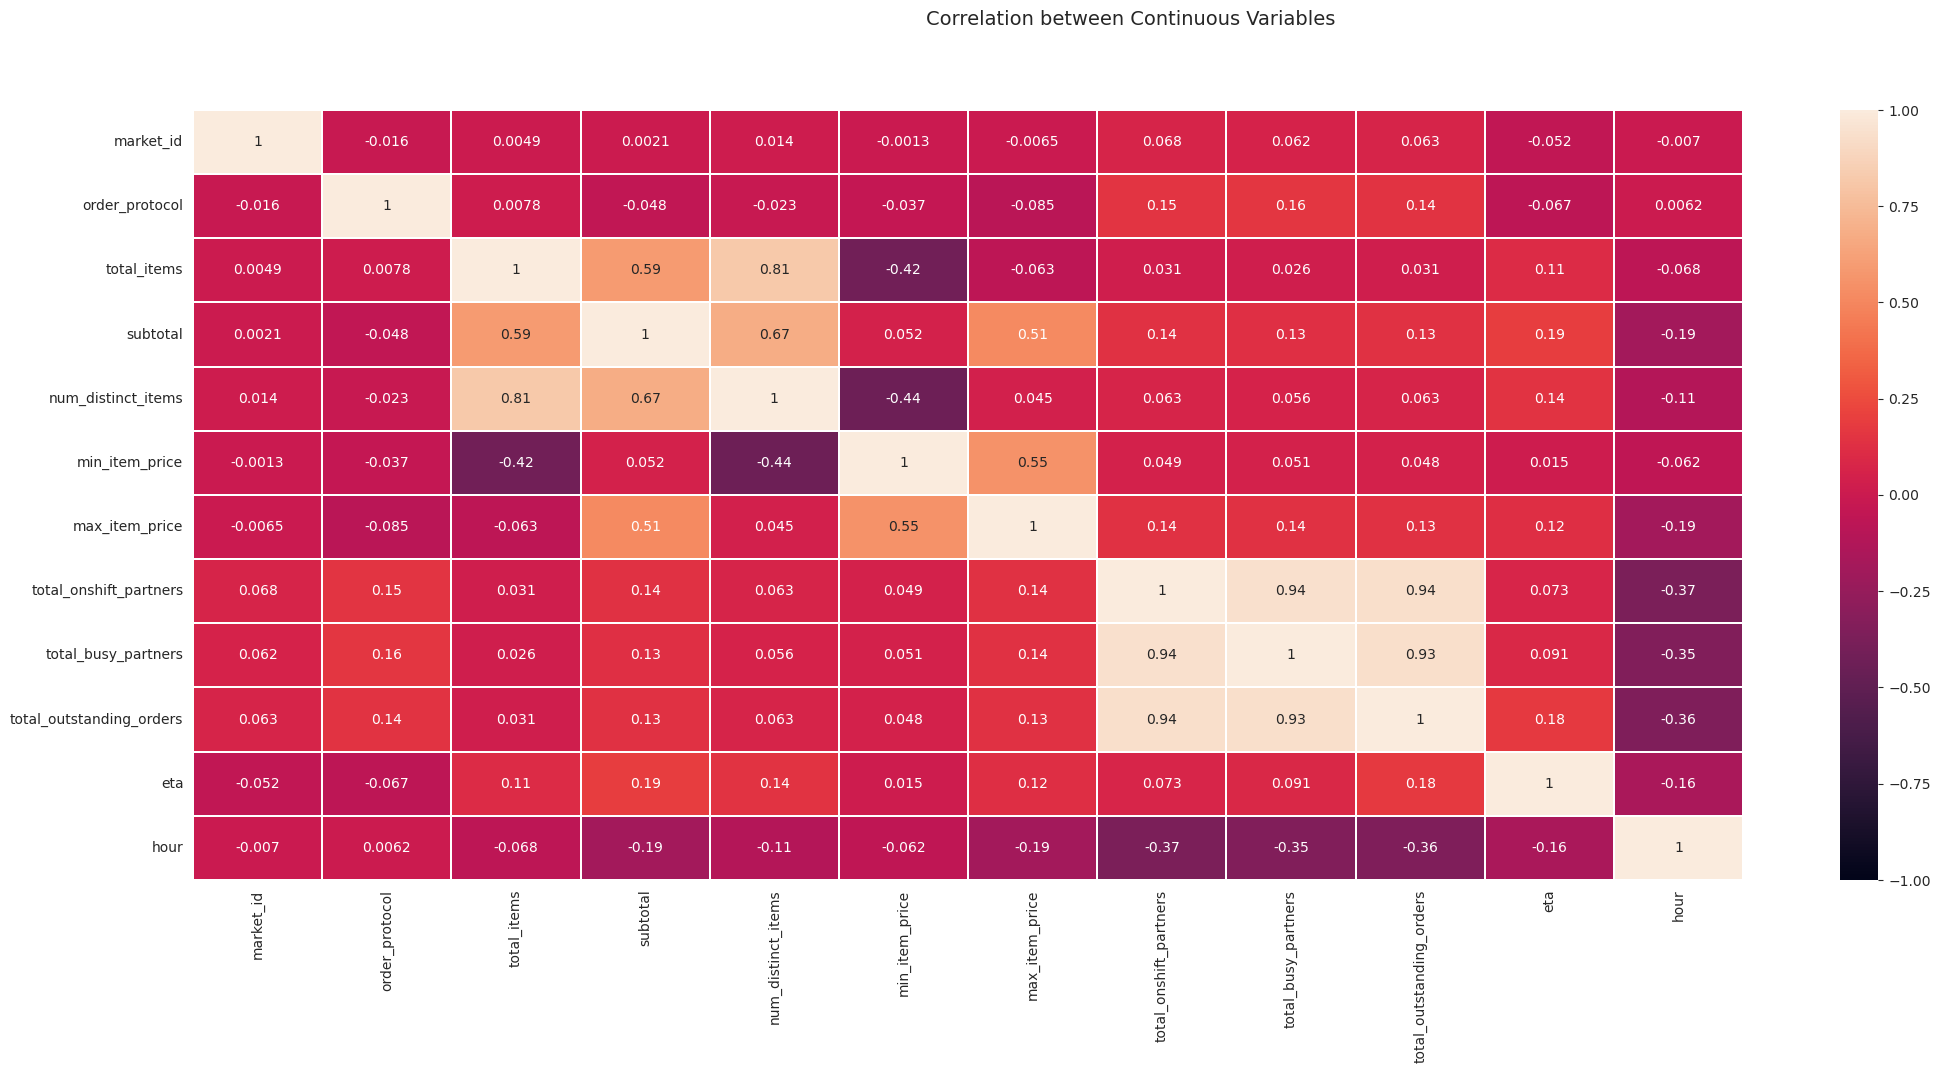

In [24]:
#---Verify Correlation Between Continuous Cols---
plt.figure(figsize=(25,10))
sns.heatmap(pandas_df.corr(numeric_only=True),annot=True,linewidths='0.01', vmin=-1,vmax=1)
plt.suptitle("Correlation between Continuous Variables", fontsize=14)
plt.show()  

**Observe**
- Total Items, Subtotal and Number of Distinct Items are Highly Correlated
- Partners and Outsanding Orders also show Very High Correlation
- Minimum Item Price shows negative COrrelation with total_items and Num of Distinct Items

In [25]:
#---Outlier Analysis---
import numpy as np

def iqr_outlier_detection(df, columns):
    bounds = {}
    for col_name in columns:
        quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
        Q1, Q3 = quantiles[0], quantiles[1]
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        bounds[col_name] = (lower_bound, upper_bound)
    
    outlier_counts = {}
    total_counts = df.count()
    
    for col_name in columns:
        lower_bound, upper_bound = bounds[col_name]
        outliers = df.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound))
        
        outlier_count = outliers.count()
        outlier_percentage = np.round( (outlier_count / total_counts) * 100,2)
        
        outlier_counts[col_name] = outlier_percentage
    
    return outlier_counts

iqr_outlier_detection(df,continuous_cols)

{'total_items': 4.86,
 'subtotal': 6.39,
 'min_item_price': 3.24,
 'max_item_price': 5.36,
 'total_onshift_partners': 2.16,
 'total_busy_partners': 1.46,
 'total_outstanding_orders': 4.66}

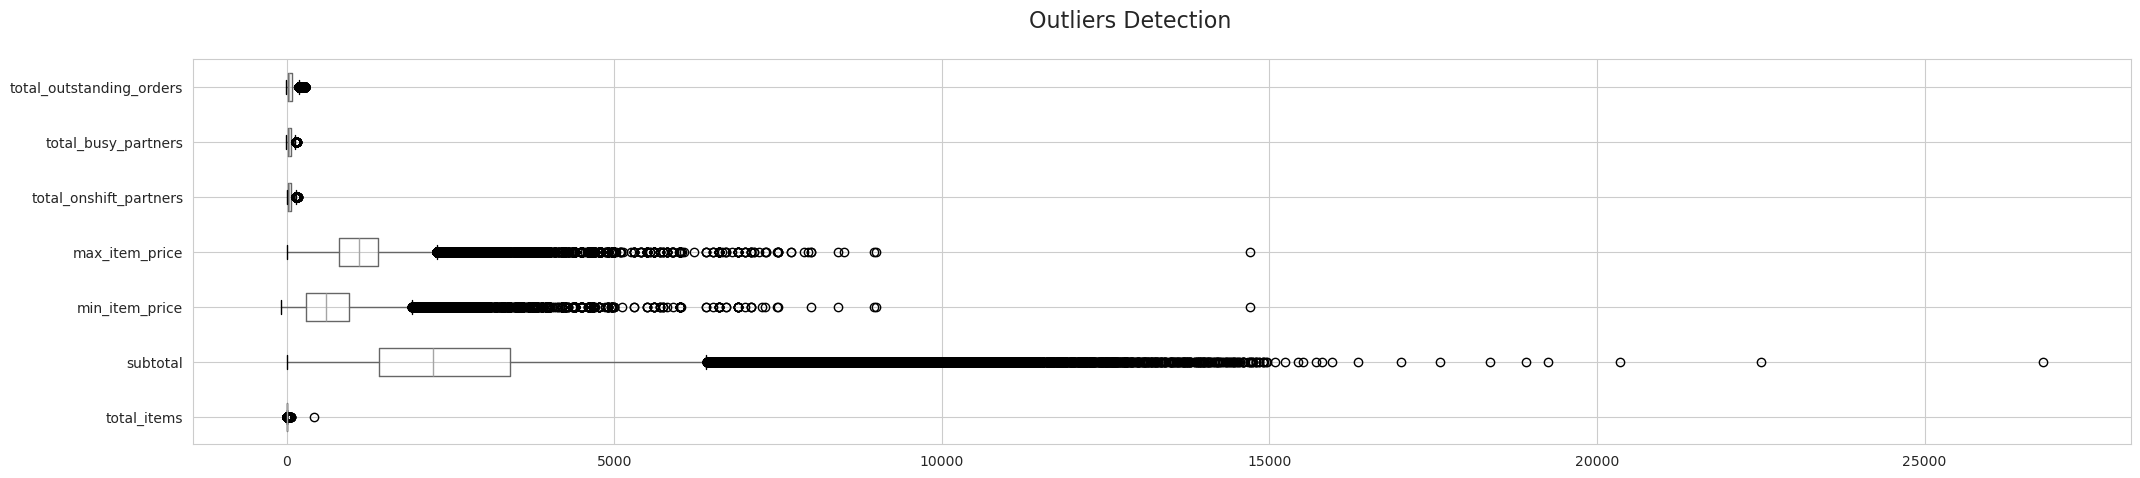

In [26]:
# Plotting Boxplot
df.select(*continuous_cols).dropna().toPandas().boxplot(vert=False,figsize=(25,5))
plt.suptitle("Outliers Detection", fontsize = 16)
plt.show()


**Observe**
- Outliers observed in total_items, max_item_price and subtotal most.

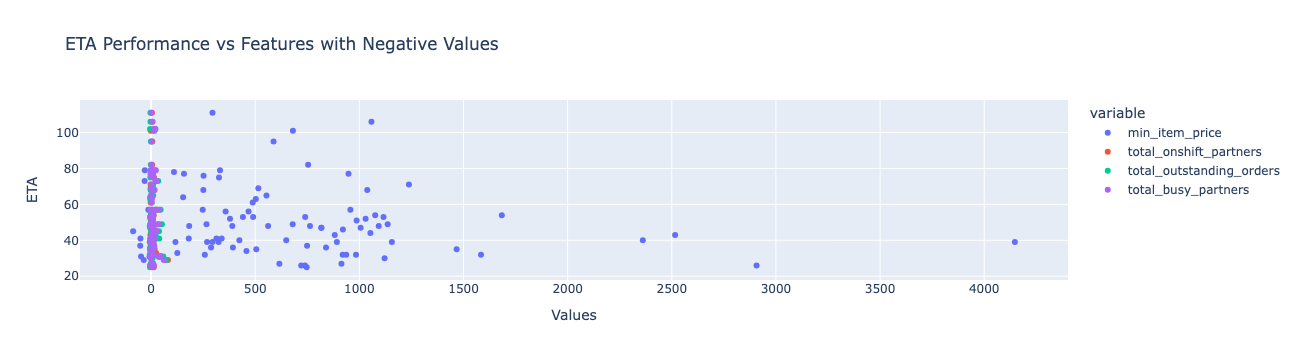

In [53]:
from pyspark.sql.functions import col
import plotly.express as px

negative_cols = ['min_item_price','total_onshift_partners','total_outstanding_orders','total_busy_partners']

negative_pd_df = df.filter( (col('min_item_price')<0) | (col('total_onshift_partners')<0)  | (col('total_outstanding_orders')<0) 
          | (col('total_busy_partners')<0)  ).select(*negative_cols+['eta']).dropna().toPandas()

melted_df = negative_pd_df.melt(id_vars=['eta'], value_vars=negative_cols, var_name='variable', value_name='value')

fig = px.scatter(melted_df, x='value', y='eta',color='variable',title='ETA Performance vs Features with Negative Values')
fig.update_layout(xaxis_title='Values', yaxis_title='ETA')
fig.show()

**Observe**
- Negative Vlaues could indicate, refund ore free product in min item price
- Negative values in other could denote a state where deleviry personals are available in excess or less.

# Data Preprocessing